In [1]:
from sklearn.metrics import mean_squared_error
from sklift.metrics import uplift_auc_score
from sklift.viz import plot_uplift_curve
from catenets.models.jax import TNet, SNet1,SNet2,DRNet
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from causalml.metrics import auuc_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


/data/home/yilingliu/miniconda3/envs/pytorch_aws/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed=123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# Load dataset
criteo_data_path = "/data/home/yilingliu/MTML/experiments/CRITEO/criteo_uplift_v2.1.csv"
dataset = pd.read_csv(criteo_data_path)


Here is a detailed description of the fields original dataset:

- **f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11**: feature values (dense, float)

- **treatment**: treatment group. Flag if a company participates in the RTB auction for a particular user (binary: 1 = treated, 0 = control)

- **exposure**: treatment effect, whether the user has been effectively exposed. Flag if a company wins in the RTB auction for the user (binary)

- **conversion**: whether a conversion occured for this user (binary, label)

- **visit**: whether a visit occured for this user (binary, label)

In [3]:
dataset.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [4]:
dataset.tail()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,1,0,0,0
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1,0
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
13979591,12.616365,10.059654,8.214383,4.679882,10.280525,3.013064,0.294443,9.332563,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [5]:
dataset.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01,8.500001e-01,2.916680e-03,4.699200e-02,3.063122e-02
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02,3.570713e-01,5.392748e-02,2.116217e-01,1.723164e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
print('Number NA:', dataset.isna().sum().sum())

Number NA: 0


<Axes: xlabel='treatment', ylabel='count'>

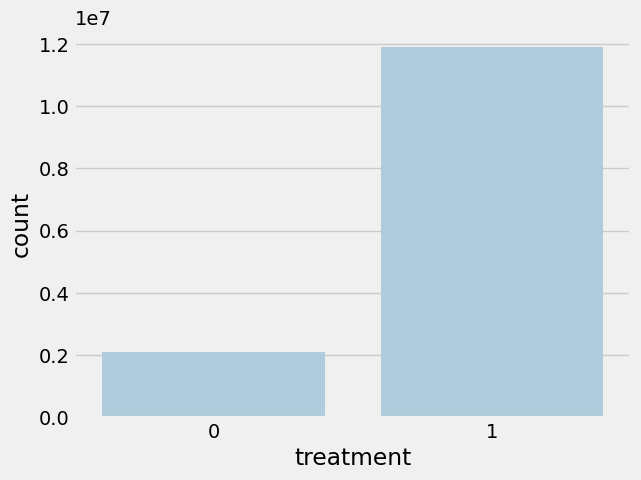

In [7]:
sns.countplot(x=dataset.treatment)

In [8]:
dataset.treatment.value_counts()

treatment
1    11882655
0     2096937
Name: count, dtype: int64

In [9]:
dataset.conversion.value_counts()

conversion
0    13938818
1       40774
Name: count, dtype: int64

In [10]:
dataset.visit.value_counts()

visit
0    13322663
1      656929
Name: count, dtype: int64

In [14]:
pd.crosstab(dataset.visit, dataset.conversion)

conversion,0,1
visit,,
0,13322663,0
1,616155,40774


In [15]:
pd.crosstab(dataset.treatment, dataset.conversion)

conversion,0,1
treatment,,
0,2092874,4063
1,11845944,36711


In [16]:
pd.crosstab(dataset.treatment, dataset.visit)

visit,0,1
treatment,,
0,2016832,80105
1,11305831,576824


In [ ]:
# Example: Generating random data for features f0 to f11
np.random.seed(42)  # For reproducibility


# Plotting the distribution of each feature
fig, axes = plt.subplots(4, 3, figsize=(15, 10))  # 4x3 grid of subplots
axes = axes.flatten()  # Flatten to easily iterate over the subplots

for i in range(12):
    ax = axes[i]
    feature_name = f'f{i}'
    ax.hist(dataset[feature_name], bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax.set_title(f'Distribution of {feature_name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
